# Анализ данных для интернет-магазина

__Описание данных__

__Данные для первой части__

__Файл:__ `/datasets/hypothesis.csv`

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

__Данные для второй части__

__Файл:__ `/datasets/orders.csv`

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

__Файл:__ `/datasets/visitors.csv`

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

__Цель:__ Приоритизировать гипотезы, запустите A/B-тест и проанализировать результаты. 

__План работ:__

1. Загрузка данных и подготовка данных
2. Приоритизация гипотез
    - применить фреймворк ICE для приоритизации гипотез.
    - применить фреймворк RICE для приоритизации гипотез. 
    - указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.
3. Анализ A/B-теста
    - Построить график кумулятивной выручки по группам. 
    - Построить график кумулятивного среднего чека по группам. 
    - Построить график относительного изменения кумулятивного среднего чека группы B к группе A. 
    - Построить график кумулятивного среднего количества заказов на посетителя по группам. 
    - Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 
    - Построить точечный график количества заказов по пользователям. 
    - Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
    - Построить точечный график стоимостей заказов. 
    - Посчитать 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
    - Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 
    - Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
    - Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 
    - Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
    - Сформировать решение по результатам теста.

### Загрузка данных и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv', parse_dates = ['date'])
    visitors = pd.read_csv('/datasets/visitors.csv.csv', parse_dates = ['date'])
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', parse_dates = ['date'])
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', parse_dates = ['date'])
    

In [3]:
pd.options.display.max_colwidth = 130

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
hypothesis.columns = hypothesis.columns.str.lower()

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
orders.group.unique()

array(['B', 'A'], dtype=object)

In [10]:
orders.date.min()

Timestamp('2019-08-01 00:00:00')

In [11]:
orders.date.max()

Timestamp('2019-08-31 00:00:00')

In [12]:
orders.groupby('group').agg({'visitorId' : 'count'})

,visitorId
group,
A,557
B,640


In [13]:
orders.duplicated().sum()

0

In [14]:
group_a = orders.query('group == "A"')['visitorId']
group_b = orders.query('group == "B"')['visitorId']
common_vis = group_b[group_b.isin(group_a)]
display(common_vis.nunique())

58

In [15]:
orders = orders.query('visitorId not in @common_vis')

In [16]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [18]:
visitors.group.unique()

array(['A', 'B'], dtype=object)

In [19]:
visitors.duplicated().sum()

0

In [20]:
visitors.groupby('group').agg({'visitors' : 'sum'})

,visitors
group,
A,18736
B,18916


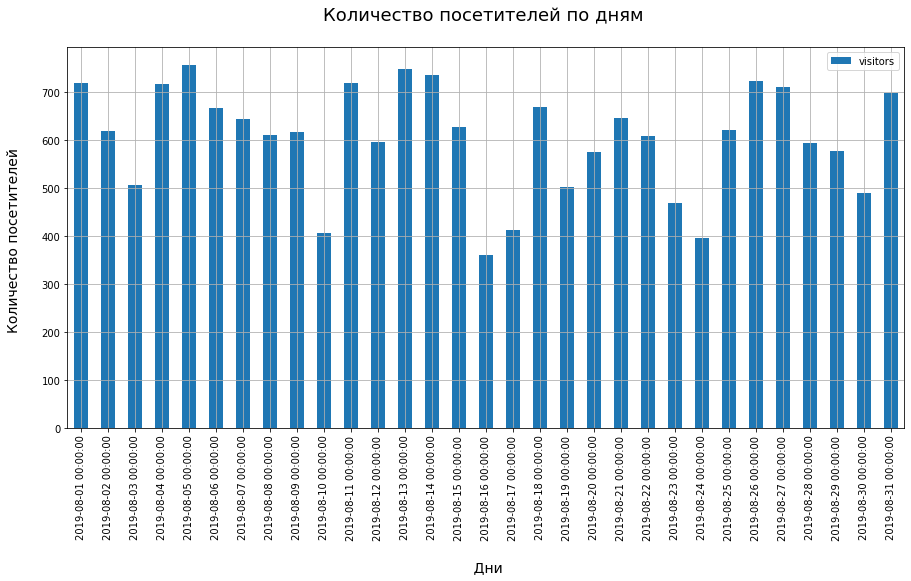

In [21]:
visitors[visitors['group'] =='A'].plot(kind='bar', figsize=(15, 7), x='date', y='visitors')
plt.title('Количество посетителей по дням \n', fontsize=18)
plt.xlabel('\n Дни', fontsize=14)
plt.ylabel('Количество посетителей \n', fontsize=14)
plt.grid(visible=True)
plt.show();

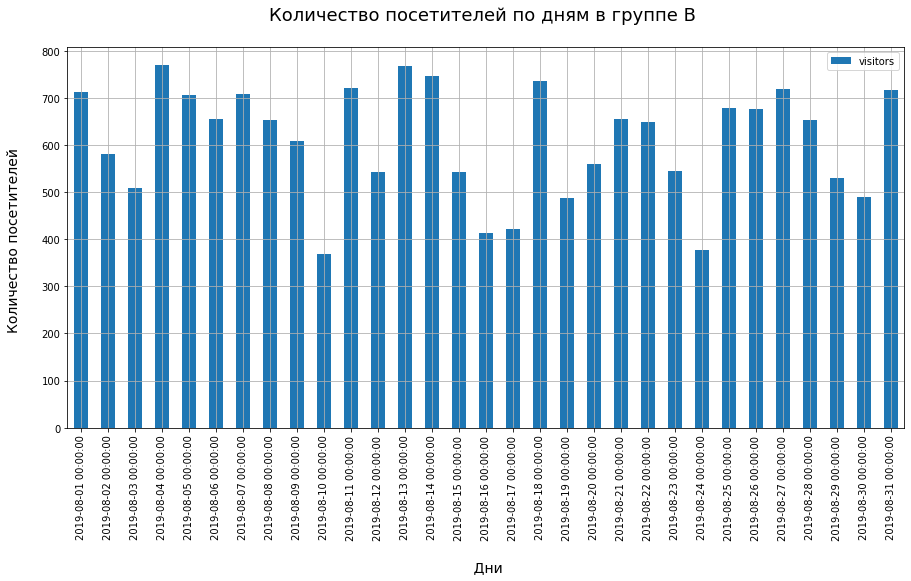

In [22]:
visitors[visitors['group'] == 'B'].plot(kind='bar', figsize=(15, 7), x='date', y='visitors')
plt.title('Количество посетителей по дням в группе B \n', fontsize=18)
plt.xlabel('\n Дни', fontsize=14)
plt.ylabel('Количество посетителей \n', fontsize=14)
plt.grid(visible=True)
plt.show();

#### Вывод

Данные загружены, преобразованы в датафрейм без ошибок. 

- Пропуски в данных отсуствуют 
- Полные дубликаты отсуствуют
- Столбцы с датами приведены к соотвествующему типу данных. 
- Названия столбцов во всех датафреймах приведены к единому стилю.
- Всего в данных информация о двух группах "А" и "В"
- Есть 58 пользователя, которые выходят и в ту и другую группу, они были исключены для более наглядной разницы между группами
- Динамика количества пользователей по дням между группами примерно одинаковая и колеблется в зависимости от дня недели, с наиболее выраженным спадом по субботам 

### Приоритизация гипотез

#### Оценка гипотез по ICE

In [23]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Видим, что по ICE первые три места занимают гипотезы "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

#### Оценка гипотез по RICE

In [24]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Видим, что по RICE первые два места занимают гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа", третье место делят гипотезы "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"

#### Вывод

После оценки по фреймворку RICE видно, что на первое место вышли другие гипотезы, нежели при оценке по фреймворку ICE. Такое различие объясняется большими значениями параметра `reach`, как это можно видеть в таблице ниже. Эти гипотезы охыватывают большее количество пользователей.
Таким образом, наиоболее приоритетной выглядит гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"

In [25]:
hypothesis.sort_values('reach', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


### Анализ A/B-теста

#### График кумулятивной выручки по группам

In [26]:
dates_groups = orders[['date','group']].drop_duplicates()

orders_agg = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_agg = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])


cumulative_data = orders_agg.merge(
    visitors_agg, left_on=['date', 'group'], right_on=['date', 'group']
)

cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulative_rev_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_rev_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

display(cumulative_data.date.min())
display(cumulative_data.date.max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

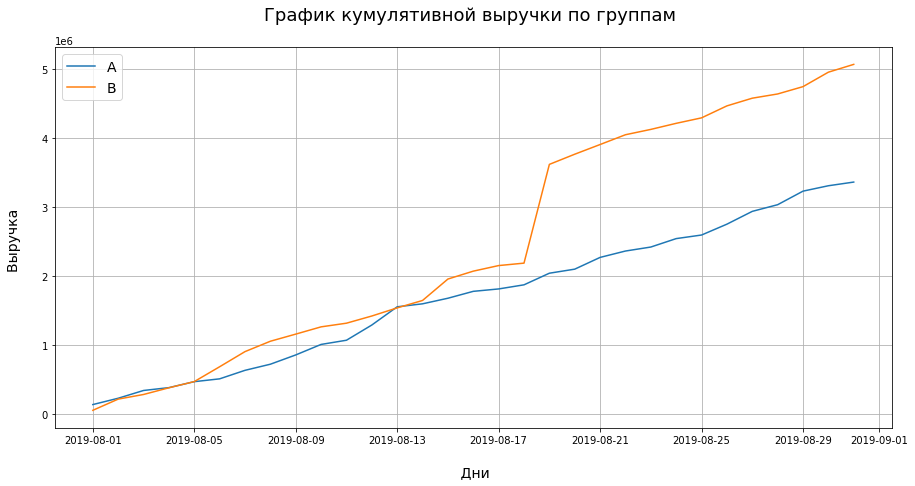

In [27]:
plt.figure(figsize=(15, 7))
plt.title('График кумулятивной выручки по группам \n', fontsize=18)
plt.plot(cumulative_rev_A['date'], cumulative_rev_A['revenue'], label='A')
plt.plot(cumulative_rev_B['date'], cumulative_rev_B['revenue'], label='B')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('\n Дни', fontsize=14)
plt.ylabel('Выручка \n', fontsize=14)
plt.grid(visible=True)
plt.show();

##### Вывод и предположения
По графику кумулятивной выручки видим, что выручка в обих группах стабильно растёт. Выручка группы B увеличивается несколько быстрее и в промежутке между 17 августа и 21 августа совершает резкий скачок. 

Можно предположить, что:
- либо в это время были произведены покупки на большую сумму.
- либо в этот период резко увеличилось количество заказов в группе B
- также, возможны оба этих варианта вместе

#### График кумулятивного среднего чека по группам

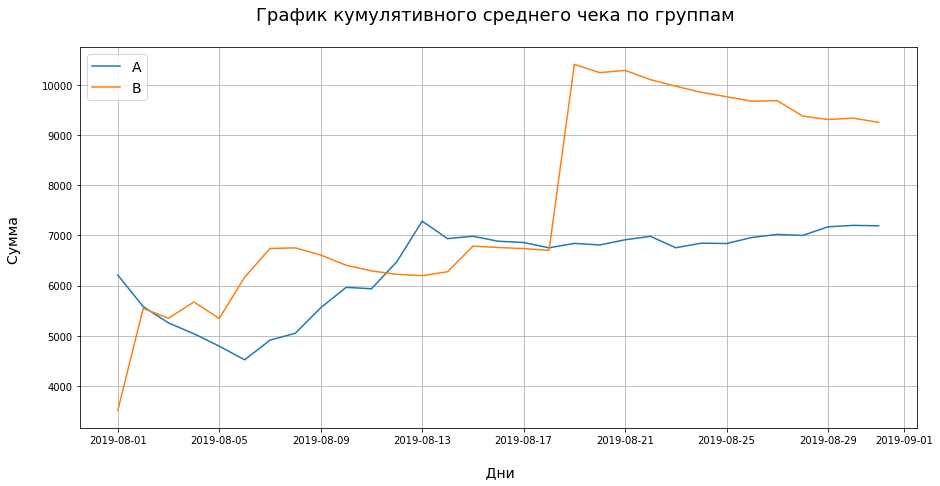

In [28]:
plt.figure(figsize=(15, 7))
plt.title('График кумулятивного среднего чека по группам \n', fontsize=18)
plt.plot(cumulative_rev_A['date'], cumulative_rev_A['revenue']/cumulative_rev_A['orders'], label='A')
plt.plot(cumulative_rev_B['date'], cumulative_rev_B['revenue']/cumulative_rev_B['orders'], label='B')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('\n Дни', fontsize=14)
plt.ylabel('Сумма \n', fontsize=14)
plt.grid(visible=True)
plt.show();

##### Вывод и предположения
По графику кумулятивного среднего чека видим, что в промежутке между 17 августа и 21 августа в группе B средний чек резко увеличивается, а затем стабильно уменьшается. Вероятно в этот промежуток времени были соверешены покупки на большую сумму.

Также видно, что у группы А чек устойчиво растёт в начале и стабилизируется ближе к концу теста.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

In [29]:
merged_cumulative_rev = cumulative_rev_A.merge(cumulative_rev_B, 
                                               left_on='date', 
                                               right_on='date', 
                                               how='left', 
                                               suffixes=['A', 'B'])

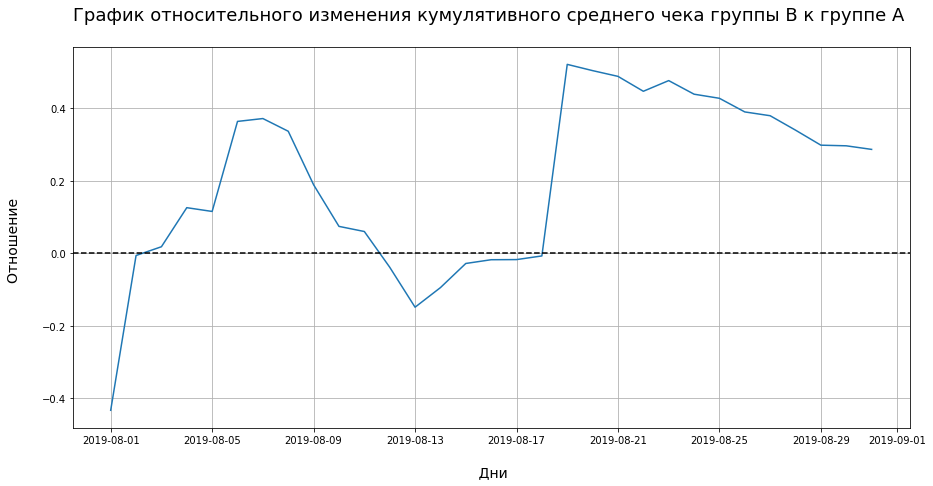

In [30]:
plt.figure(figsize=(15, 7))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A \n', fontsize=18)
plt.plot(merged_cumulative_rev['date'], 
         (merged_cumulative_rev['revenueB']/
          merged_cumulative_rev['ordersB'])/
         (merged_cumulative_rev['revenueA']/
          merged_cumulative_rev['ordersA'])-1)
plt.grid(visible=True)
plt.xlabel('\n Дни', fontsize=14)
plt.ylabel('Отношение \n', fontsize=14)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

##### Вывод и предположения

На графике относительного изменения кумулятивного среднего чека так же видим скачки: один в начале теста, а второй уже в знаком промежутке времени между 17 августа и 21 августа.

Всё говорит в пользу предположения о больших покупках в этот период

#### График кумулятивного среднего количества заказов на посетителя по группам

In [31]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

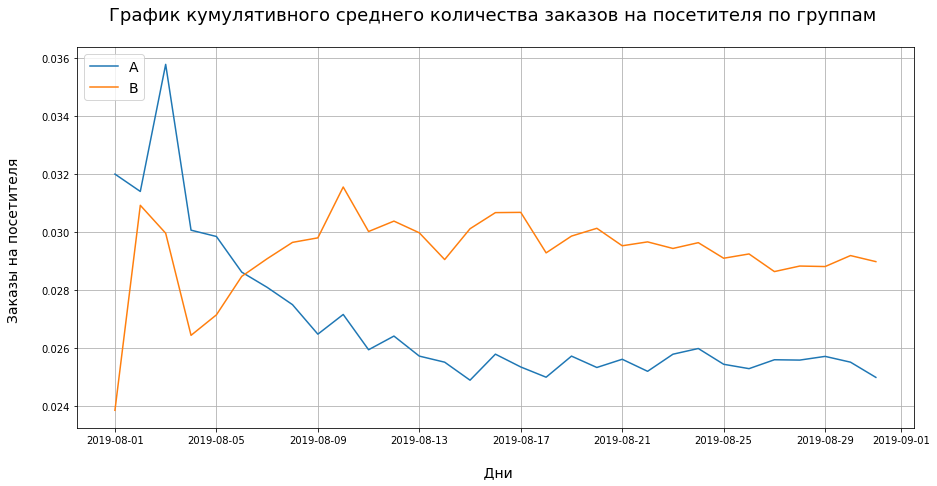

In [32]:
plt.figure(figsize=(15, 7))
plt.title('График кумулятивного среднего количества заказов на посетителя по группам \n', fontsize=18)
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('\n Дни', fontsize=14)
plt.ylabel('Заказы на посетителя \n', fontsize=14)
plt.grid(visible=True)
plt.show();

##### Вывод и предположения

По графику видно, что в группе А изначально совершалось больше заказов, чем в группе B. 
Среднее количество заказов в группах сначала резко растёт, затем в группе А - стремительно падает и стабилизируется, а в группе B так же стремительно растёт и стабилизируется.


Роста числа заказов в группе B на период между 17 августа и 21 августа не наблюдается, что опять же говорит в пользу покупок на большие суммы.
Также возможно, что были совершенны покупки на большую сумму 13 августа в группе А, т.к. среднее количество покупок на посетителя минимально в этот день, в то время, как средний чек самый большой в группе А за весь период теста.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

In [33]:
merged_cumulative_conv = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], 
                                                                        left_on='date', 
                                                                        right_on='date', 
                                                                        how='left', 
                                                                        suffixes=['A', 'B'])

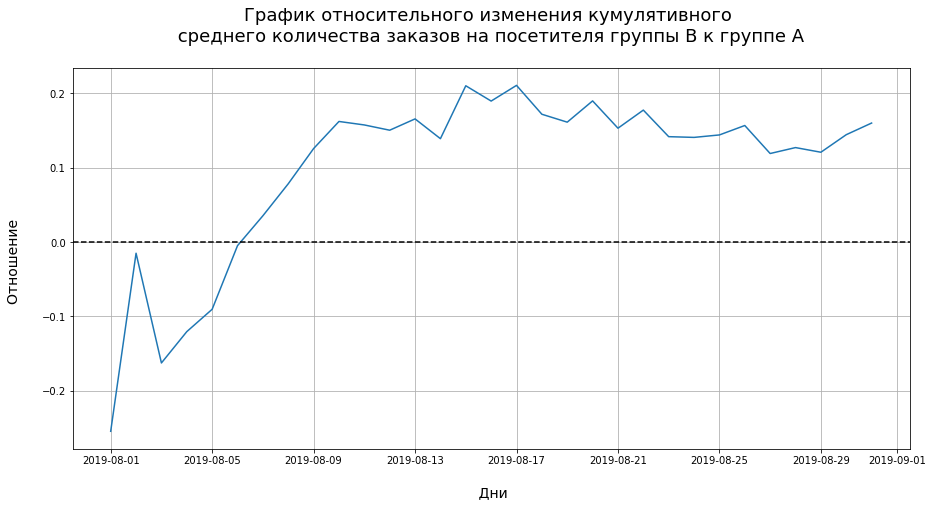

In [34]:
plt.figure(figsize=(15, 7))
plt.title('График относительного изменения кумулятивного \n среднего количества заказов на посетителя группы B к группе A \n', 
          fontsize=18)
plt.plot(merged_cumulative_conv['date'], merged_cumulative_conv['conversionB']/merged_cumulative_conv['conversionA']-1)
plt.xlabel('\n Дни', fontsize=14)
plt.ylabel('Отношение \n', fontsize=14)
plt.grid(visible=True)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

##### Вывод и предположения

В начале теста группа B проигрывала группе A по числу заказов на посетителя, затем стремительно вырвалась вперёд. Потом среднее количество заказов на посетителя для группы B начало стабилизироваться

#### Точечный график количества заказов по пользователям

In [35]:
orders_by_visitor = (orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'}))
orders_by_visitor.columns = ['visitorId', 'orders']

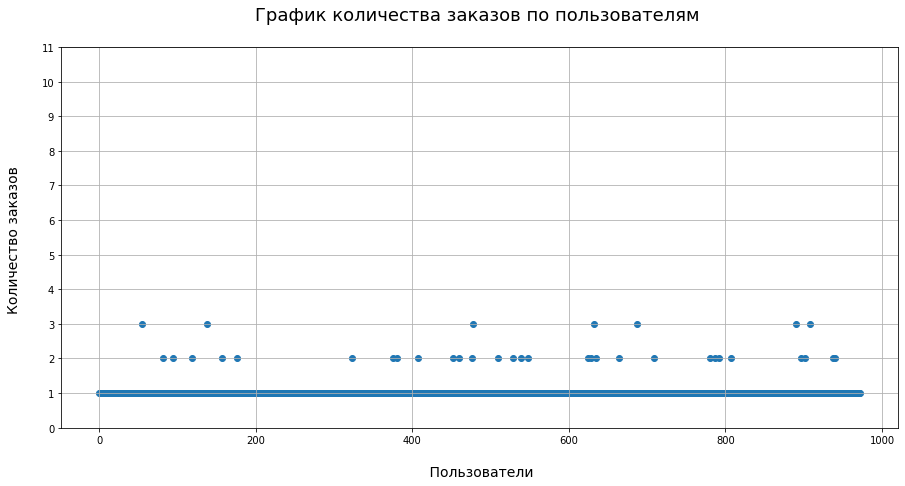

In [36]:
x_values = pd.Series(range(0,len(orders_by_visitor)))

plt.figure(figsize=(15, 7))
plt.title('График количества заказов по пользователям \n', fontsize=18)
plt.scatter(x_values, orders_by_visitor['orders'])
plt.xlabel('\n Пользователи', fontsize=14)
plt.ylabel('Количество заказов \n', fontsize=14)
plt.yticks(range(0,12))
plt.grid(visible=True)
plt.show()

##### Вывод и предположения

На графике видно, что большая часть пользователей совершила по одному заказу. Небольшое количество пользователей совершенил 2-3 зказа

#### 95-й и 99-й перцентили количества заказов на пользователя.

In [37]:
print(np.percentile(orders_by_visitor['orders'], [95, 99]))

[1. 2.]


Видим, что только 1% пользователей соврешило более 2 заказов.
Примем за аномальных пользователей тех, кто сделал более 2 заказов

#### Точечный график стоимостей заказов

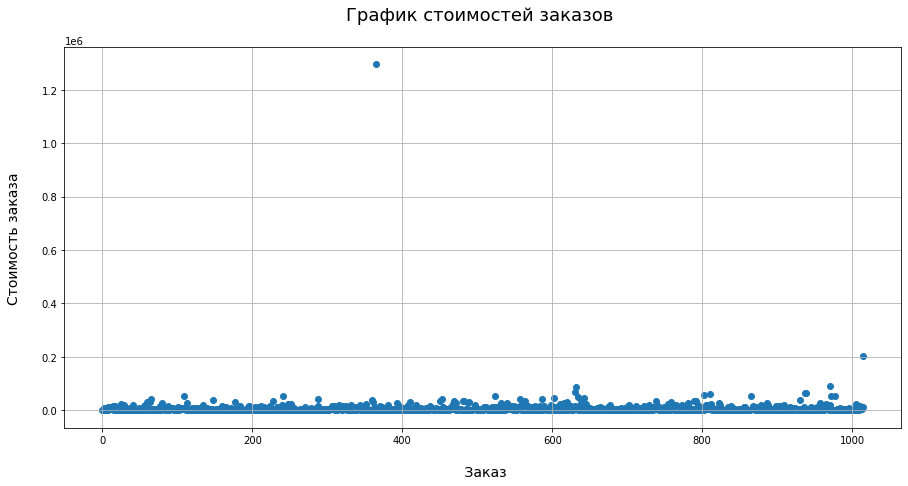

In [38]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15, 7))
plt.title('График стоимостей заказов \n', fontsize=18)
plt.scatter(x_values, orders['revenue'])
plt.xlabel('\n Заказ', fontsize=14)
plt.ylabel('Стоимость заказа\n', fontsize=14)
plt.grid(visible=True)
plt.show()

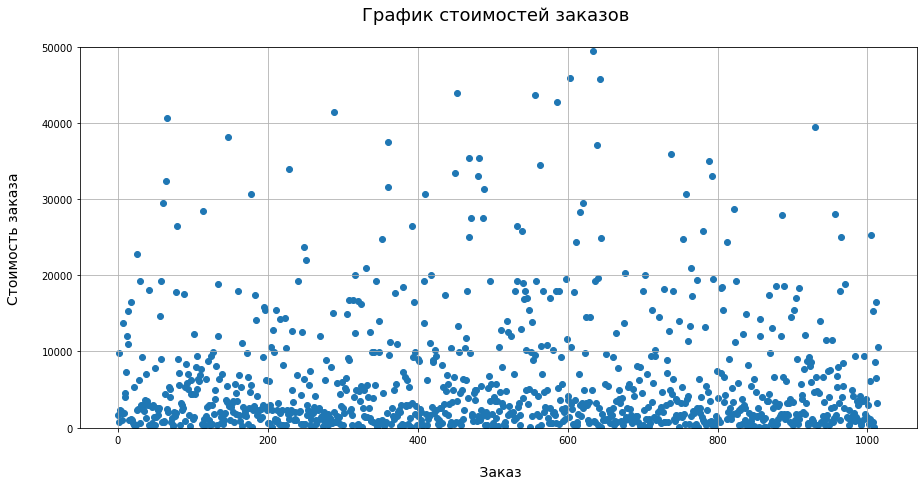

In [39]:
plt.figure(figsize=(15, 7))
plt.title('График стоимостей заказов \n', fontsize=18)
plt.scatter(x_values, orders['revenue'])
plt.xlabel('\n Заказ', fontsize=14)
plt.ylabel('Стоимость заказа\n', fontsize=14)
plt.ylim([0, 50000])
plt.grid(visible=True)
plt.show()

##### Вывод и предположения

На графике видно, что большая часть заказов на сумму менее 10 тысяч. Есть два особо выделяющихся заказа на крупные суммы более 200 тысяч.

Возможно, именно их мы видели в виде скачков на графиках средних чеков и выручки

#### 95-й и 99-й перцентили стоимости заказов

In [40]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[17990. 26785. 53904.]


Видим, что 5% покупок на сумму свыше 28 тысяч, 1% более 53 тысяч.
Примем за аномальные заказы с суммой свыше 26785

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [41]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_A']

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
]

orders_B_daily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
]

df = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

In [42]:
orders_by_vis_A = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
orders_by_vis_A.columns = ['visitorId', 'orders']

orders_by_vis_B = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
orders_by_vis_B.columns = ['visitorId', 'orders']

sample_A = pd.concat([orders_by_vis_A['orders'],
                     pd.Series(0, 
                               index=np.arange(df['visitors_per_date_A'].sum() - len(orders_by_vis_A['orders'])), 
                                name='orders')],
                            axis=0)

sample_B = pd.concat([orders_by_vis_B['orders'],
                      pd.Series(0, 
                                index=np.arange(df['visitors_per_date_B'].sum() - len(orders_by_vis_B['orders'])), 
                                name='orders')],
                             axis=0) 

In [43]:
# т.к. данные с выбросами, применяем тест Манна-Уитни
# Нулевая гипотеза - различий в среднем количестве заказов на посетителя между группами нет
# Альтернативная гипотеза - различия в среднем количестве заказов на посетителя есть

test_result = st.mannwhitneyu(sample_A, sample_B)[1]

print('P-value равно', "{0:.3f}".format(test_result))

if test_result < 0.05:
    print('P-value меньше уровня статистической значимости, отвергаем гипотезу')
else:
    print('P-value больше уровня статистической значимости, нельзя отвергнуть гипотезу')
    
print("Относительный прирост среднего числа заказов группы В: {0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

P-value равно 0.011
P-value меньше уровня статистической значимости, отвергаем гипотезу
Относительный прирост среднего числа заказов группы В: 0.160


#####  Выводы и предположения

По результатам теста на сырых данных, можно предположить, что между средним количеством заказов на посетителя в группах есть значимая разница.

Прирост среднего числа заказов составил 16% в группе В 

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

In [44]:
# Нулевая гипотеза - различий в среднем чеке нет
# Альтернативная гипотеза - различия в среднем чеке есть

test_result = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('P-value равно','{0:.3f}'.format(test_result))

if test_result < 0.05:
    print('P-value меньше уровня статистической значимости, отвергаем гипотезу')
else:
    print('P-value больше уровня статистической значимости, нельзя отвергнуть гипотезу')
    
print("Относительный прирост среднего чека группы В: {0:.3f}".format(
    orders[orders['group']=='A']['revenue'].mean() / orders[orders['group']=='B']['revenue'].mean() - 1))

P-value равно 0.829
P-value больше уровня статистической значимости, нельзя отвергнуть гипотезу
Относительный прирост среднего чека группы В: -0.223


#####  Выводы и предположения

По результатам теста на сырых данных, нельзя отвергнуть гипотезу о равенстве срдених чеков группы А и B

Прирост среднего чека на стороне группы А

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [45]:
# находим аномальных пользователей

vis_w_many_orders = pd.concat(
    [
        orders_by_vis_A[orders_by_vis_A['orders'] > np.percentile(orders_by_visitor['orders'], [99])[0]]['visitorId'],
        orders_by_vis_B[orders_by_vis_B['orders'] > np.percentile(orders_by_visitor['orders'], [99])[0]]['visitorId'],
    ],
    axis=0,
)

vis_w_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], [99])[0]]['visitorId']

abnormal_vis = (
    pd.concat([vis_w_many_orders, vis_w_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormal_vis.shape[0]

16

In [46]:
# фильтруем выборки

sample_A_filtered = pd.concat(
    [
        orders_by_vis_A[
            np.logical_not(orders_by_vis_A['visitorId'].isin(abnormal_vis))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitors_per_date_A'].sum() - len(orders_by_vis_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_vis_B[
            np.logical_not(orders_by_vis_B['visitorId'].isin(abnormal_vis))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitors_per_date_B'].sum() - len(orders_by_vis_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [47]:
# Нулевая гипотеза - различий в среднем количестве заказов на посетителя между группами нет
# Альтернативная гипотеза - различия в среднем количестве заказов на посетителя нет

test_result = st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]

print('P-value равно', "{0:.3f}".format(test_result))

if test_result < 0.05:
    print('P-value меньше уровня статистической значимости, отвергаем гипотезу')
else:
    print('P-value больше уровня статистической значимости, нельзя отвергнуть гипотезу')
    
print("Относительный прирост среднего числа заказов группы В: {0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

P-value равно 0.009
P-value меньше уровня статистической значимости, отвергаем гипотезу
Относительный прирост среднего числа заказов группы В: 0.160


#####  Выводы и предположения

По результатам теста на очищенных данных, можно предположить, что между средним количеством заказов на посетителя в группах есть значимая разница

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [48]:
# Нулевая гипотеза - различий в среднем чеке нет
# Альтернативная гипотеза - различия в среднем чеке есть

test_result = st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormal_vis)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormal_vis)),
                )
            ]['revenue'],
        )[1]

In [49]:
print('P-value равно','{0:.3f}'.format(test_result))

if test_result < 0.05:
    print('P-value меньше уровня статистической значимости, отвергаем гипотезу')
else:
    print('P-value больше уровня статистической значимости, нельзя отвергнуть гипотезу')
    
print("Относительный прирост среднего чека группы В: {0:.3f}".format(
    orders[orders['group']=='A']['revenue'].mean() / orders[orders['group']=='B']['revenue'].mean() - 1))

P-value равно 0.788
P-value больше уровня статистической значимости, нельзя отвергнуть гипотезу
Относительный прирост среднего чека группы В: -0.223


#####  Выводы и предположения

По результатам теста на очищенных данных, нельзя отвергнуть гипотезу о равенстве средних чеков группы А и B

#### Решение по результатам теста

По результатам A/B теста известно следующее: 
- Можно предположить, что между средним количеством заказов на посетителя в группах есть значимая разница;
- График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A, показывает что результаты группы B лучше, чем в группе А;
- Несмотря на это, нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

В этой связи, оптимальным решением будет остановка теста, и признание победы группы B в количестве заказов, но отсутствие значимой разницы в средних чеках между группами.

### Выводы

1. Данные загружены, преобразованы в датафрейм без ошибок. 

- Пропуски в данных отсутствуют 
- Полные дубликаты отсутствуют
- Столбцы с датами приведены к соответствующему типу данных. 
- Названия столбцов во всех датафреймах приведены к единому стилю.
- Всего в данных информация о двух группах "А" и "В"
- Есть 58 пользователя, которые выходят и в ту и другую группу, они были исключены для более наглядной разницы между группами
- Динамика количества пользователей по дням между группами примерно одинаковая и колеблется в зависимости от дня недели, с наиболее выраженным спадом по субботам 

2. После оценки по фреймворку RICE видно, что на первое место вышли другие гипотезы, нежели при оценке по фреймворку ICE. Такое различие объясняется большими значениями параметра `reach`, как это можно видеть в таблице ниже. Эти гипотезы охватывают большее количество пользователей. Таким образом, наиболее приоритетной выглядит гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"

3. По результатам A/B теста известно следующее:
- По графику кумулятивной выручки видим, что выручка в обоих группах стабильно растёт. Выручка группы B увеличивается несколько быстрее и в промежутке между 17 августа и 21 августа совершает резкий скачок. 
- По графику кумулятивного среднего чека видим, что в промежутке между 17 августа и 21 августа в группе B средний чек резко увеличивается, а затем стабильно уменьшается.
- На графике относительного изменения кумулятивного среднего чека так же видим скачки: один в начале текста, а второй уже в знаком промежутке времени между 17 августа и 21 августа.
- По графику видно, что в группе А изначально совершалось больше заказов, чем в группе B. Среднее количество заказов в группах сначала резко растёт, затем в группе А - стремительно падает и стабилизируется, а в группе B так же стремительно растёт и стабилизируется.
- В начале теста группа B проигрывала группе A по числу заказов на посетителя, затем стремительно вырвалась вперёд. Потом среднее количество заказов на посетителя для группы B начало стабилизироваться
- Только 5% пользователей совершило более 2 заказов, и только 1% более 4
- 5% покупок на сумму свыше 28 тысяч, 1% более 58 тысяч
- По результатам теста на сырых данных, можно предположить, что между средним количеством заказов на посетителя в группах есть значимая разница
- По результатам теста на сырых данных, нельзя отвергнуть гипотезу о равенстве средних чеков группы А и B
- По результатам теста на очищенных данных, можно предположить, что между средним количеством заказов на посетителя в группах есть значимая разница
- По результатам теста на очищенных данных, нельзя отвергнуть гипотезу о равенстве средних чеков группы А и B

4. Оптимальным решением будет остановка теста, и признание победы группы B в количестве заказов, но отсутствие значимой разницы в средних чеках между группами.